# People Detection and Crowd-sizing

Setup & Installs:

In [1]:
!pip -q install --upgrade ultralytics==8.3.40 kaggle opencv-python pandas==2.2.2 matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.6 MB/s eta 0:00:00


### import libraries

In [2]:
# All imports are done first
import os, random, zipfile, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import files
from ultralytics import YOLO
import kagglehub

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Reproducibility
random.seed(42)
np.random.seed(42)

# # GPU Check
# import torch

# print("CUDA working: ", torch.cuda.is_available())
# print("GPU name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Path Setups
root = Path("/content")
project_root = root / "people_detection"
data_root = project_root / "data"
image_exts = (".jpg", ".jpeg", ".png")

In [4]:
# Clean old subsets for safe reruns
if project_root.exists():
  print("Removing old subset")
  shutil.rmtree(project_root)
project_root.mkdir(parents = True, exist_ok = True)

### Dataset Download & Subset Creation

In [5]:
download_path = kagglehub.dataset_download("adilshamim8/people-detection")

print("Path to dataset files:", download_path)

100%|██████████| 1.94G/1.94G [00:15<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adilshamim8/people-detection/versions/1


In [6]:
# Copy dataset into your project data directory
(project_root / "data").mkdir(parents=True, exist_ok=True)

splits = ['train', 'valid', 'test']

for split_name in splits:
    source_dir = Path(download_path) / split_name / split_name # Corrected to include nested split_name
    destination_dir = data_root / split_name

    if source_dir.exists():
        # Remove existing destination directory to ensure a fresh copy
        if destination_dir.exists():
            shutil.rmtree(destination_dir)
            print(f"Removed existing '{destination_dir}' for a fresh copy.")

        shutil.copytree(source_dir, destination_dir)
        print(f"Copied '{source_dir}' to '{destination_dir}'.")
    else:
        print(f"Source directory '{source_dir}' does not exist. Skipping.")


print("Dataset copied successfully")

Copied '/root/.cache/kagglehub/datasets/adilshamim8/people-detection/versions/1/train/train' to '/content/people_detection/data/train'.
Copied '/root/.cache/kagglehub/datasets/adilshamim8/people-detection/versions/1/valid/valid' to '/content/people_detection/data/valid'.
Copied '/root/.cache/kagglehub/datasets/adilshamim8/people-detection/versions/1/test/test' to '/content/people_detection/data/test'.
Dataset copied successfully


## Generate the corresponding labels of images

In [9]:

CLASS_MAP = {"person": 0}

def process_split(split):
    split_dir = data_root / split
    csv_path = split_dir / "_annotations.csv"

    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"

    images_dir.mkdir(exist_ok=True)
    labels_dir.mkdir(exist_ok=True)

    # Load annotations
    df = pd.read_csv(csv_path)

    required = {
        "filename", "width", "height",
        "class", "xmin", "ymin", "xmax", "ymax"
    }
    if not required.issubset(df.columns):
        raise ValueError(f"{split}: CSV missing required columns")

    # ---- Deterministic order ----
    df = df.sort_values("filename")

    # ---- Move images into images/ ----
    for p in split_dir.iterdir():
        if p.suffix.lower() in image_exts:
            shutil.move(str(p), images_dir / p.name)

    # ---- Write YOLO labels ----
    for img_name, rows in df.groupby("filename"):
        label_path = labels_dir / f"{Path(img_name).stem}.txt"

        with open(label_path, "w") as f:
            for _, r in rows.iterrows():
                cls_name = str(r["class"]).strip().lower()

                if cls_name not in CLASS_MAP:
                    raise ValueError(f"Unknown class '{cls_name}'")

                cls_id = CLASS_MAP[cls_name]

                x_center = ((r.xmin + r.xmax) / 2) / r.width
                y_center = ((r.ymin + r.ymax) / 2) / r.height
                box_w = (r.xmax - r.xmin) / r.width
                box_h = (r.ymax - r.ymin) / r.height

                f.write(
                    f"{cls_id} "
                    f"{x_center:.6f} {y_center:.6f} "
                    f"{box_w:.6f} {box_h:.6f}\n"
                )

    # ---- Remove CSV ----
    csv_path.unlink()

    print(f"{split}: {df['filename'].nunique()} labels generated")


for split in splits:
    process_split(split)

train: 13278 labels generated
valid: 1370 labels generated
test: 738 labels generated


## EDA

## count the images and corresponding labels per split

In [14]:
# count the images and corresponding labels per split
from typing import List


splits = {
    "train": data_root / "train" / "images",
    "val": data_root / "valid" / "images",
    "test": data_root / "test" / "images",
}

label_dirs = {
    "train": data_root / "train" / "labels",
    "val": data_root / "valid" / "labels",
    "test": data_root / "test" / "labels",
}

def list_images(split_name: str) -> List[Path]:
    """Lists image files for a given split."""
    if split_name not in splits:
        raise ValueError(f"Unknown split name: {split_name}")
    return sorted(
        p for p in splits[split_name].iterdir()
        if p.suffix.lower() in image_exts
    )

def label_path(img_path: Path, split_name: str) -> Path:
    """Returns label path for a given image."""
    if split_name not in label_dirs:
        raise ValueError(f"Unknown split name: {split_name}")
    return label_dirs[split_name] / f"{img_path.stem}.txt"

counts = []

for split_name in splits.keys():
    imgs = list_images(split_name)
    lbls = sorted(label_dirs[split_name].glob("*.txt"))

    counts.append({
        "split": split_name,
        "images": len(imgs),
        "labels": len(lbls),
    })

display(pd.DataFrame(counts))

split  images  labels
0  train   15210   13278
1    val    1431    1370
2   test     760     738

## Check for missing/extra labels and verify images open

In [16]:
from PIL import Image

missing_labels = []
extra_labels = []
corrupt_images = []

for split in splits.keys():
    img_dir = splits[split]
    lbl_dir = label_dirs[split]

    imgs = sorted(
        p for p in img_dir.iterdir()
        if p.suffix.lower() in image_exts
    )

    img_names = {p.stem for p in imgs}
    lbl_names = {p.stem for p in lbl_dir.glob("*.txt")}

    # ---- Missing & extra labels ----
    for name in sorted(img_names - lbl_names):
        missing_labels.append((split, name))

    for name in sorted(lbl_names - img_names):
        extra_labels.append((split, name))

    # ---- Image corruption check ----
    for p in imgs:
        try:
            with Image.open(p) as im:
                im.verify()   # lightweight validation
        except Exception as e:
            corrupt_images.append((split, p.name, str(e)))


print(f"Missing labels: {len(missing_labels)}")
print(f"Extra labels: {len(extra_labels)}")
print(f"Corrupt images: {len(corrupt_images)}")

if missing_labels:
    print("Missing label examples:", missing_labels[:5])

if extra_labels:
    print("Extra label examples:", extra_labels[:5])

if corrupt_images:
    print("Corrupt image examples:", corrupt_images[:2])

Missing labels: 2015
Extra labels: 0
Corrupt images: 0
Missing label examples: [('train', '000070_jpg.rf.084f3859a0193bbb8c251b3b046b619f'), ('train', '000286_jpg.rf.aa19449f34e5b9ccae1f251cd7645c47'), ('train', '000356_jpg.rf.f2867c4c7d703b4b50b91b38a6714b27'), ('train', '000511_jpg.rf.ce6b5f5ed8d8f3a3b7519ecad7144ca1'), ('train', '000511_jpg.rf.d6655d322dcab40a80661529ca6fd536')]


## Bounding box analysis

In [18]:
from typing import List, Dict

records: List[Dict] = []

for split in splits.keys():
    imgs = list_images(split)

    for img_path in imgs:
        lbl_path = label_path(img_path, split)

        # Get image dimensions
        with Image.open(img_path) as im:
            w, h = im.size

        # Skip if label file does not exist
        if not lbl_path.exists():
            continue

        label_text = lbl_path.read_text().strip()
        if not label_text:
            continue   # empty label = background image

        # Parse YOLO boxes
        for line in label_text.splitlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            cls, xc, yc, bw, bh = map(float, parts)

            records.append({
                "split": split,
                "image": img_path.name,
                "class_id": int(cls),
                "img_w": w,
                "img_h": h,
                "box_w_norm": bw,
                "box_h_norm": bh,
                "box_w_px": bw * w,
                "box_h_px": bh * h,
                "box_area_pct": bw * bh * 100,
                "box_aspect": (bw / bh) if bh > 0 else np.nan,
            })

boxes_df = pd.DataFrame.from_records(records)

print(f"Total boxes: {len(boxes_df)}")
boxes_df.head()

Total boxes: 113548


split                                              image  class_id  img_w  \
0  train  -Blvd-Antonio-l-Rodriguez-188-Conference-Room-...         0    784   
1  train  -Blvd-Antonio-l-Rodriguez-188-Conference-Room-...         0    784   
2  train  -Blvd-Antonio-l-Rodriguez-188-Conference-Room-...         0    784   
3  train  -Blvd-Antonio-l-Rodriguez-188-Conference-Room-...         0    784   
4  train  -Blvd-Antonio-l-Rodriguez-188-Conference-Room-...         0    784   

   img_h  box_w_norm  box_h_norm    box_w_px   box_h_px  box_area_pct  \
0    590    0.149235    0.225424  117.000240  133.00016      3.364115   
1    590    0.048469    0.052542   37.999696   30.99978      0.254666   
2    590    0.029337    0.098305   23.000208   57.99995      0.288397   
3    590    0.029337    0.094915   23.000208   55.99985      0.278452   
4    590    0.028061    0.094915   21.999824   55.99985      0.266341   

   box_aspect  
0    0.662019  
1    0.922481  
2    0.298428  
3    0.309087  
4    0.295643

## Images analysis

In [19]:
# Image-level stats; size, aspect

image_rows = []
for split in splits:
    for img_path in list_images(split):
        with Image.open(img_path) as im:
            w, h = im.size
        image_rows.append({
            "split": split,
            "image": img_path.name,
            "width": w,
            "height": h,
            "aspect": w / h,
        })

images_df = pd.DataFrame(image_rows)
print(images_df.describe())

              width        height        aspect
count  17401.000000  17401.000000  17401.000000
mean     904.510545    617.172634      1.408587
std      642.238319    371.115144      0.342335
min      100.000000     88.000000      0.374000
25%      492.000000    375.000000      1.237354
50%      556.000000    496.000000      1.336957
75%     1234.000000    712.000000      1.777778
max     4624.000000   3468.000000      4.545455


## Visualize train image with bounding box

2010_006275_jpg.rf.2156edb44b407a1f74a0219dbb751826.jpg


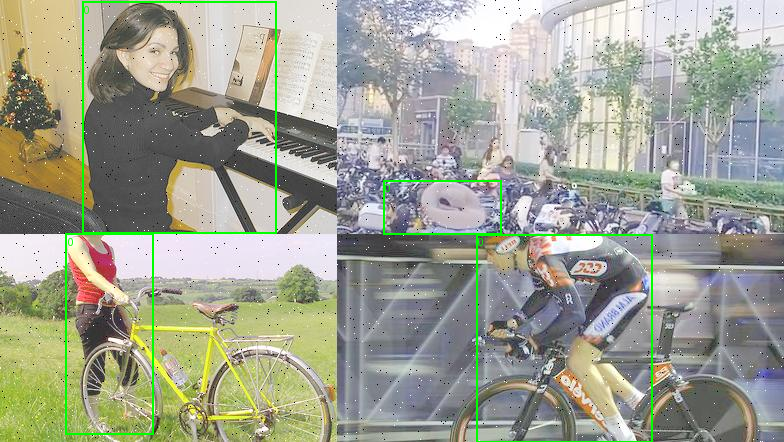

1496724_jpg.rf.f6334340842d2f777773255e9c3cd187.jpg


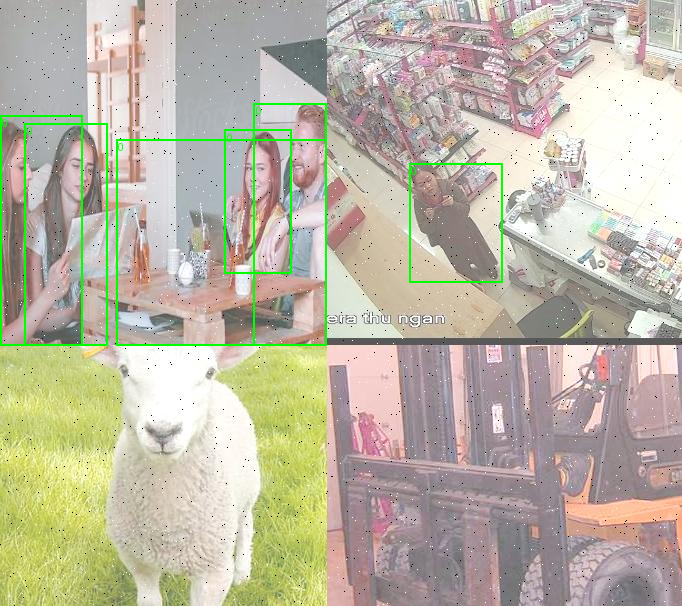

2010_003731_jpg.rf.fdb9e608879a0367ba34c409f015b00e.jpg


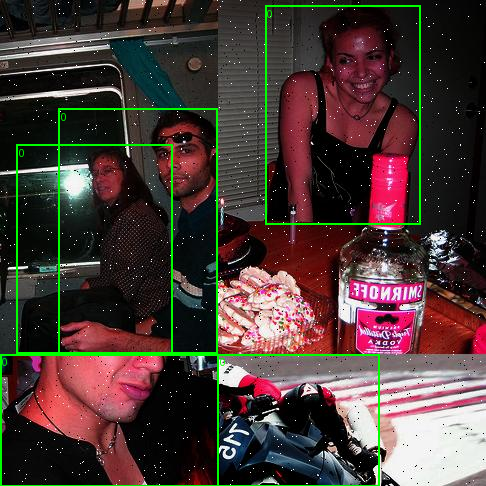

2010_006351_jpg.rf.28e49e3f99ce70a378fa05835a3cf0e7.jpg


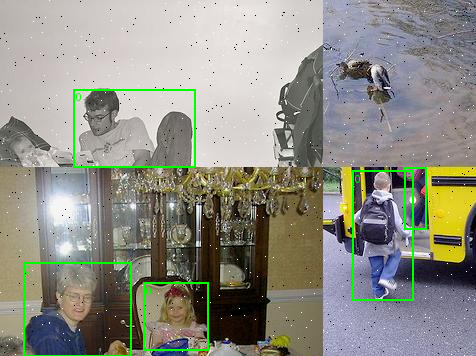

In [23]:
from PIL import Image, ImageDraw
from pathlib import Path
import random

train_image_path = data_root / "train" / "images"


def draw_boxes(image_path: Path, labels_path: Path):
    im = Image.open(image_path).convert("RGB")
    w, h = im.size
    draw = ImageDraw.Draw(im)

    if labels_path.exists():
        label_text = labels_path.read_text().strip()
        if label_text:
            for line in label_text.splitlines():
                cls, xc, yc, bw, bh = map(float, line.split())

                # Convert YOLO to pixel coords
                x0 = (xc - bw / 2) * w
                y0 = (yc - bh / 2) * h
                x1 = (xc + bw / 2) * w
                y1 = (yc + bh / 2) * h

                draw.rectangle([x0, y0, x1, y1], outline="lime", width=2)
                draw.text((x0 + 2, y0 + 2), str(int(cls)), fill="lime")

    return im


num_show = 4

all_imgs = sorted(
    p for p in train_image_path.iterdir()
    if p.suffix.lower() in image_exts
)

sample = random.sample(all_imgs, k=min(num_show, len(all_imgs)))

for img_path in sample:
    lbl_path = label_dirs["train"] / f"{img_path.stem}.txt"

    annotated = draw_boxes(img_path, lbl_path)
    print(img_path.name)
    display(annotated)

## Pre-processing

- generate labels file for missing labels

In [24]:
from pathlib import Path

created = []

for split, img_stem in missing_labels:
    lbl_dir = label_dirs[split]
    lbl_path = lbl_dir / f"{img_stem}.txt"

    if not lbl_path.exists():
        lbl_path.touch()
        created.append(lbl_path)

print(f"Created {len(created)} empty label files")

Created 2015 empty label files


#### Get subset of data from the train dataset

In [25]:
# Get a subset with 20% of the data with maximum images set to 3000
def collect_images(base: Path):
  return sorted([p for p in base.rglob("*") if p.suffix.lower() in image_exts])

train_images = collect_images(data_root / "train" / "images")
print(f"Total images found: {len(train_images)}")

Total images found: 15210


In [ ]:
# subset_fraction = 0.20
# n_target = int(len(train_images) * subset_fraction)
# n_max = 3000
# n_subset = min(n_target, n_max)
# print(f"Using {n_subset} images (20% of the total data, capped at {n_max})")

# subset_images = random.sample(train_images, n_subset)
# random.shuffle(subset_images)
# split_idx = int(len(subset_images) * 0.8)
# subset_train_images = subset_images[:split_idx]
# subset_val_images = subset_images[split_idx:]
# print(f"Subset split: {len(subset_train_images)} train / {len(subset_val_images)} val")


In [ ]:
# subset_data_path = data_root / "subset"
# subset_data_path.mkdir(parents = True, exist_ok = True)

# images_train = subset_data_path / "images/train"
# images_val = subset_data_path / "images/val"
# labels_train = subset_data_path / "labels/train"
# labels_val = subset_data_path / "labels/val"

# for p in [images_train, images_val, labels_train, labels_val]:
#   p.mkdir(parents = True, exist_ok = True)

# def safe_link(src: Path, dst: Path):
#   try:
#     os.symlink(src, dst)
#   except:
#     shutil.copy(src, dst)

# for img in subset_train_images:
#   safe_link(img, images_train / img.name)

# for img in subset_val_images:
#   safe_link(img, images_val / img.name)

# print("Subset images copied")

In [26]:
import math
subset_data_path = data_root / "subset"

src_images = data_root / "train" / "images"
src_labels = data_root / "train" / "labels"

dst_images = subset_data_path / "train" / "images"
dst_labels = subset_data_path / "train" / "labels"

dst_images.mkdir(parents=True, exist_ok=True)
dst_labels.mkdir(parents=True, exist_ok=True)

train_images = collect_images(src_images)
n_total = len(train_images)

subset_size = min(3000, math.ceil(0.2 * n_total))

print(f"Total images found: {n_total}")
print(f"Subset size (20%, cap 3000): {subset_size}")

subset_images = train_images[:subset_size]

# Copy images and matching labels ----
for img in subset_images:
    lbl = src_labels / f"{img.stem}.txt"

    if not lbl.exists():
        raise FileNotFoundError(f"Missing label for {img.name}")

    shutil.copy2(img, dst_images / img.name)
    shutil.copy2(lbl, dst_labels / lbl.name)

print("Subset data extraction complete")

Total images found: 15210
Subset size (20%, cap 3000): 3000
Subset data extraction complete


- split subset data into train/val set

In [27]:
val_img_dir = subset_data_path / "val" / "images"
val_lbl_dir = subset_data_path / "val" / "labels"

val_img_dir.mkdir(parents=True, exist_ok=True)
val_lbl_dir.mkdir(parents=True, exist_ok=True)

subset_images = collect_images(dst_images)
n_subset = len(subset_images)

val_size = math.ceil(0.2 * n_subset)

print(f"Subset images: {n_subset}")
print(f"Validation size: {val_size}")
print(f"Training size after split: {n_subset - val_size}")

val_images = subset_images[-val_size:]
keep_train_images = subset_images[:-val_size]

#  Move validation images with labels
for img in val_images:
    lbl = dst_labels / f"{img.stem}.txt"

    shutil.move(img, val_img_dir / img.name)
    shutil.move(lbl, val_lbl_dir / lbl.name)

print("Train/Val split complete")

Subset images: 3000
Validation size: 600
Training size after split: 2400
Train/Val split complete


#### Create the training config

In [30]:
# Create data.yaml for this subset
data_yaml = subset_data_path / "people_subset.yaml"

data_yaml.write_text(
    f"path: {subset_data_path}\n"
    f"train: train/images\n"
    f"val: val/images\n"
    f"names:\n"
    f"  0: person\n"
)

print("data.yaml:\n", data_yaml.read_text())

data.yaml:
 path: /content/people_detection/data/subset
train: train/images
val: val/images
names:
  0: person



#### Hyperparameter Search (CFG1 vs CFG2)
- determine the best training parameters

In [34]:
image_size = 640

configurations = [
    {"name": "cfg1", "epochs": 8, "imgsz": image_size, "lr0": 0.002},
    {"name": "cfg2", "epochs": 10, "imgsz": image_size, "lr0": 0.0015},
]

runs_dir = project_root / "people_runs"
runs_dir.mkdir(parents=True, exist_ok=True)

hpo_rows = []

for cfg in configurations:
    print(f"\nRunning configuration: {cfg}")

    model = YOLO("yolov8n.pt")

    # ---- Train ----
    model.train(
        data=str(data_yaml),
        epochs=cfg["epochs"],
        imgsz=cfg["imgsz"],
        lr0=cfg["lr0"],
        batch=16,
        optimizer="auto",
        project=str(runs_dir),
        name=cfg["name"],
        verbose=False,
    )


    best_weights = runs_dir / cfg["name"] / "weights" / "best.pt"
    best_model = YOLO(best_weights)

    # ---- Evaluate ----
    eval_results = best_model.val(
        data=str(data_yaml),
        imgsz=cfg["imgsz"],
        conf=0.15,
        iou=0.50,
        project=str(runs_dir),
        name=f"{cfg['name']}_eval",
        verbose=False,
    )

    # metrics
    results = eval_results.results_dict

    P = float(results.get("metrics/precision(B)", float("nan")))
    R = float(results.get("metrics/recall(B)", float("nan")))
    mAP50 = float(results.get("metrics/mAP50(B)", float("nan")))
    mAP5095 = float(results.get("metrics/mAP50-95(B)", float("nan")))

    F1 = 2 * P * R / (P + R + 1e-9)

    hpo_rows.append({
        "name": cfg["name"],
        "epochs": cfg["epochs"],
        "imgsz": cfg["imgsz"],
        "lr0": cfg["lr0"],
        "precision": P,
        "recall": R,
        "f1": F1,
        "mAP@0.5": mAP50,
        "mAP@0.5:0.95": mAP5095,
    })



Running configuration: {'name': 'cfg1', 'epochs': 8, 'imgsz': 640, 'lr0': 0.002}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/people_runs, name=cfg1, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1

train: Scanning /content/people_detection/data/subset/train/labels.cache... 2400 images, 207 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/people_detection/people_runs/cfg1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/people_detection/people_runs/cfg1
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8      3.54G      1.815      1.676      1.339        332        640: 100%|██████████| 150/150 [00:57<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.85it/s]

                   all        600       4135      0.653      0.491      0.524      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      3.85G        1.7       1.36      1.296        278        640: 100%|██████████| 150/150 [00:54<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


                   all        600       4135      0.577      0.503      0.505      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      3.98G      1.649      1.293      1.283        322        640: 100%|██████████| 150/150 [00:53<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.74it/s]


                   all        600       4135      0.604       0.51       0.53       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      3.15G        1.6      1.213      1.249        373        640: 100%|██████████| 150/150 [00:49<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]


                   all        600       4135      0.703      0.521      0.598      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8      3.53G      1.536      1.163      1.224        462        640: 100%|██████████| 150/150 [00:51<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


                   all        600       4135      0.712      0.594      0.663      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8      2.89G      1.477      1.104      1.192        356        640: 100%|██████████| 150/150 [00:56<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.89it/s]


                   all        600       4135      0.742      0.639      0.702      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      3.27G      1.412      1.045      1.168        356        640: 100%|██████████| 150/150 [00:51<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


                   all        600       4135      0.767      0.635      0.705      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      3.89G      1.364      1.002      1.147        316        640: 100%|██████████| 150/150 [00:56<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.24it/s]


                   all        600       4135       0.76      0.669      0.722      0.456

8 epochs completed in 0.142 hours.
Optimizer stripped from /content/people_detection/people_runs/cfg1/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/people_runs/cfg1/weights/best.pt, 6.2MB

Validating /content/people_detection/people_runs/cfg1/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]


                   all        600       4135      0.761      0.668      0.722      0.455
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/people_detection/people_runs/cfg1
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  4.02it/s]


                   all        600       4135      0.771      0.701      0.759      0.512
Speed: 0.3ms preprocess, 3.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/people_detection/people_runs/cfg1_eval

Running configuration: {'name': 'cfg2', 'epochs': 10, 'imgsz': 640, 'lr0': 0.0015}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/people_runs, name=cfg2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, prof

train: Scanning /content/people_detection/data/subset/train/labels.cache... 2400 images, 207 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/people_detection/people_runs/cfg2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/people_detection/people_runs/cfg2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.37G      1.827      1.735      1.361        156        640: 100%|██████████| 150/150 [00:55<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


                   all        600       4135      0.626      0.511      0.524      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.21G      1.766       1.46      1.359        160        640: 100%|██████████| 150/150 [00:55<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]


                   all        600       4135      0.654       0.46      0.508      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.17G      1.718      1.403      1.354        246        640: 100%|██████████| 150/150 [00:47<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


                   all        600       4135      0.643      0.467      0.519      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.75G      1.652      1.306      1.318        231        640: 100%|██████████| 150/150 [00:47<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]


                   all        600       4135      0.687      0.536      0.599      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.11G      1.598      1.232      1.292        181        640: 100%|██████████| 150/150 [00:47<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


                   all        600       4135      0.713      0.572      0.636      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.38G      1.542       1.18      1.263        295        640: 100%|██████████| 150/150 [00:48<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]


                   all        600       4135      0.724       0.59       0.66      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.92G      1.478      1.115      1.232        240        640: 100%|██████████| 150/150 [00:46<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


                   all        600       4135      0.749      0.597      0.662      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.62G      1.421      1.061      1.198        147        640: 100%|██████████| 150/150 [00:47<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


                   all        600       4135      0.753      0.634      0.697      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.52G      1.361       1.01       1.17        232        640: 100%|██████████| 150/150 [00:53<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


                   all        600       4135      0.779      0.648      0.716      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.28G      1.322     0.9743      1.153        219        640: 100%|██████████| 150/150 [00:47<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.10it/s]


                   all        600       4135      0.793       0.66      0.733      0.466

10 epochs completed in 0.168 hours.
Optimizer stripped from /content/people_detection/people_runs/cfg2/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/people_runs/cfg2/weights/best.pt, 6.2MB

Validating /content/people_detection/people_runs/cfg2/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.20it/s]


                   all        600       4135      0.792      0.662      0.733      0.466
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/people_detection/people_runs/cfg2
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  4.04it/s]


                   all        600       4135      0.788        0.7       0.77      0.523
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/people_detection/people_runs/cfg2_eval


In [35]:
hpo_df = pd.DataFrame(hpo_rows).copy()

metric_cols = ["precision", "recall", "f1", "mAP@0.5", "mAP@0.5:0.95"]
for col in metric_cols:
    hpo_df[col] = pd.to_numeric(hpo_df[col], errors="coerce")

print("\nHPO summary:\n", hpo_df)

# identify best config
best_row = (
    hpo_df
    .dropna(subset=["mAP@0.5"])
    .sort_values(
        by=["mAP@0.5", "f1"],
        ascending=False
    )
    .iloc[0]
)

print("\nBest configuration (by mAP@0.5):\n", best_row)

# best run
best_name = best_row["name"]
best_imgsz = int(best_row["imgsz"])

best_run_dir = runs_dir / best_name
best_weights = best_run_dir / "weights" / "best.pt"

assert best_weights.exists(), f"Missing weights: {best_weights}"
print(f"\nBest weights located at: {best_weights}")


HPO summary:
    name  epochs  imgsz     lr0  precision    recall        f1   mAP@0.5  \
0  cfg1       8    640  0.0020   0.770743  0.700838  0.734130  0.758777   
1  cfg2      10    640  0.0015   0.788471  0.700121  0.741674  0.770090   

   mAP@0.5:0.95  
0      0.511857  
1      0.522647  

Best configuration (by mAP@0.5):
 name                cfg2
epochs                10
imgsz                640
lr0               0.0015
precision       0.788471
recall          0.700121
f1              0.741674
mAP@0.5          0.77009
mAP@0.5:0.95    0.522647
Name: 1, dtype: object

Best weights located at: /content/people_detection/people_runs/cfg2/weights/best.pt


### Train Model
- Using the best model parameters

In [36]:
# Extended training, 20 epochs on best configuration

epochs = 20
name = "final_model"

model = YOLO(str(best_weights))

model.train(
    data = str(data_yaml),
    epochs = epochs,
    imgsz = best_imgsz,
    lr0 = float(best_row["lr0"]),
    batch = 16,
    optimizer="auto",
    project = str(runs_dir),
    name = name,
    verbose = False
)

final_model_weights = runs_dir / name / "weights" / "best.pt"
final_model = YOLO(final_model_weights)

New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/people_detection/people_runs/cfg2/weights/best.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/people_runs, name=final_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning /content/people_detection/data/subset/train/labels.cache... 2400 images, 207 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000187_jpg.rf.6072bb3923494a7afb8648ba483324fd.jpg: 23 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_000999_jpg.rf.6c08f70e15d4b331a62dd733f71a31ef.jpg: 7 duplicate labels removed
train: WARNING ⚠️ /content/people_detection/data/subset/train/images/2007_002260_jpg.rf.67b39e42171c963a3427b19a2abe68b4.jpg: 19 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/people_detection/people_runs/final_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/people_detection/people_runs/final_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.47G      1.435      1.054      1.184        332        640: 100%|██████████| 150/150 [00:56<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


                   all        600       4135       0.75      0.611      0.685      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.84G      1.476      1.093      1.202        278        640: 100%|██████████| 150/150 [00:58<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.20it/s]


                   all        600       4135       0.65      0.559      0.595      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.96G      1.494       1.11       1.22        322        640: 100%|██████████| 150/150 [00:54<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.72it/s]


                   all        600       4135      0.686      0.598      0.628      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.13G      1.482      1.089      1.209        373        640: 100%|██████████| 150/150 [00:54<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


                   all        600       4135      0.748      0.594      0.681      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       3.5G      1.455       1.07      1.197        462        640: 100%|██████████| 150/150 [00:52<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]


                   all        600       4135      0.728      0.611       0.69      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.87G      1.422      1.037       1.18        356        640: 100%|██████████| 150/150 [00:53<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


                   all        600       4135      0.743        0.6      0.678      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.25G      1.388      1.013      1.167        356        640: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]


                   all        600       4135      0.756      0.602      0.682      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.87G      1.369      0.983      1.156        316        640: 100%|██████████| 150/150 [00:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

                   all        600       4135      0.797      0.611      0.706      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.91G      1.346     0.9802      1.146        447        640: 100%|██████████| 150/150 [00:57<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.67it/s]

                   all        600       4135      0.794       0.64      0.726      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.1G       1.32     0.9568      1.137        308        640: 100%|██████████| 150/150 [00:53<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.55it/s]


                   all        600       4135      0.805      0.641      0.727      0.461
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       3.4G      1.281     0.9279      1.135        245        640: 100%|██████████| 150/150 [00:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.71it/s]


                   all        600       4135      0.794      0.642      0.735      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.75G      1.257     0.9024      1.127        193        640: 100%|██████████| 150/150 [00:52<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.43it/s]

                   all        600       4135      0.768      0.684      0.746      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.99G      1.224     0.8821      1.115        280        640: 100%|██████████| 150/150 [00:51<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


                   all        600       4135      0.809      0.665      0.752      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.62G        1.2     0.8598      1.104        114        640: 100%|██████████| 150/150 [00:52<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


                   all        600       4135      0.809      0.676      0.763      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.12G      1.194     0.8487      1.099        212        640: 100%|██████████| 150/150 [00:51<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.41it/s]

                   all        600       4135      0.784      0.696      0.755      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.43G      1.157     0.8159      1.084        171        640: 100%|██████████| 150/150 [00:52<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]

                   all        600       4135      0.814      0.688      0.769      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.24G      1.128     0.8052      1.077        110        640: 100%|██████████| 150/150 [01:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]

                   all        600       4135        0.8      0.694      0.765      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.12G      1.115     0.7817      1.064        152        640: 100%|██████████| 150/150 [00:53<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]

                   all        600       4135      0.802      0.696      0.771      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.29G      1.094     0.7658      1.051        116        640: 100%|██████████| 150/150 [00:48<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.91it/s]

                   all        600       4135      0.813      0.709      0.777      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.36G      1.061     0.7433      1.042        177        640: 100%|██████████| 150/150 [00:50<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.53it/s]


                   all        600       4135      0.814      0.712      0.782      0.532

20 epochs completed in 0.345 hours.
Optimizer stripped from /content/people_detection/people_runs/final_model/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/people_runs/final_model/weights/best.pt, 6.2MB

Validating /content/people_detection/people_runs/final_model/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]


                   all        600       4135      0.814      0.712      0.782      0.532
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/people_detection/people_runs/final_model


- Evaluate model on validation set

In [37]:
eval = final_model.val(
    data = str(data_yaml),
    imgsz = best_imgsz,
    conf = 0.15,
    iou = 0.50,
    project = str(runs_dir),
    name = f"{name}_eval",
    verbose = False
)

try:
  P = float(eval.box.p.mean())
  R = float(eval.box.r.mean())
  mAP50 = float(eval.box.map50)
  map5095 = float(eval.box.map)
except AttributeError:
  P = float(eval.results_dict.get("metrics/precision(B)", float("nan")))
  R = float(eval.results_dict.get("metrics/recall(B)", float("nan")))
  mAP50 = float(eval.results_dict.get("metrics/mAP50(B)", float("nan")))
  map5095 = float(eval.results_dict.get("metrics/mAP50-95(B)", float("nan")))

F1 = 2 * P * R / (P + R + 1e-9)

print("\nExtended training results:")
print(f"Precision: {P:.4f}")
print(f"Recall: {R:.4f}")
print(f"F1: {F1:.3f}")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {map5095:.4f}")

# best_model = model
# best_run_dir = runs_dir / name

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/val/labels.cache... 600 images, 146 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  4.09it/s]


                   all        600       4135      0.816      0.737       0.81      0.589
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/people_detection/people_runs/final_model_eval

Extended training results:
Precision: 0.8158
Recall: 0.7367
F1: 0.774
mAP@0.5: 0.8100
mAP@0.5:0.95: 0.5893


#### Optimize counting performance

In [40]:
import torch
import gc
import os
# torch.cuda.empty_cache()
# gc.collect()

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [41]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def load_label_counts(label_folder: Path):
    counts = {}
    for lf in label_folder.glob("*.txt"):
        with open(lf, "r") as f:
            lines = [ln for ln in f.read().splitlines() if ln.strip()]
        counts[lf.stem] = len(lines)
    return counts

## Model Evaluation

In [42]:
label_counts_val = load_label_counts(val_lbl_dir)
val_imgs = sorted(p for p in val_img_dir.iterdir() if p.suffix.lower() in image_exts)

print(f"Validation images: {len(val_imgs)}, label files: {len(label_counts_val)}")

conf_list = [0.20, 0.25, 0.30]
iou_list = [0.45, 0.50, 0.55]

rows = []

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16

final_model.eval()

for conf in conf_list:
    for iou in iou_list:
        preds = []

        with torch.no_grad():
            for batch in chunks(val_imgs, batch_size):
                results = final_model.predict(
                    source=batch,
                    imgsz=best_imgsz,
                    conf=conf,
                    iou=iou,
                    device=device,
                    verbose=False,
                    max_det=200,
                )

                for r in results:
                    name = Path(r.path).stem
                    if r.boxes is not None and r.boxes.cls.numel() > 0:
                        n_pred = int((r.boxes.cls == 0).sum())
                    else:
                        n_pred = 0

                    n_true = label_counts_val.get(name, 0)
                    preds.append((n_true, n_pred))

        df = pd.DataFrame(preds, columns=["true", "pred"])

        df["err"] = df["pred"] - df["true"]
        df["abs_err"] = df["err"].abs()
        df["sq_err"] = df["err"] ** 2

        corr = (
            df[["true", "pred"]].corr().iloc[0, 1]
            if df["true"].std() > 0 and df["pred"].std() > 0
            else np.nan
        )

        rows.append({
            "conf": conf,
            "iou": iou,
            "MAE": df["abs_err"].mean(),
            "RMSE": np.sqrt(df["sq_err"].mean()),
            "Corr": corr,
        })

sweep_df = pd.DataFrame(rows).sort_values("MAE")
print(sweep_df)

Validation images: 600, label files: 600
   conf   iou       MAE      RMSE      Corr
0  0.20  0.45  1.421667  2.646696  0.960080
1  0.20  0.50  1.433333  2.643861  0.960069
5  0.25  0.55  1.448333  2.967884  0.950824
4  0.25  0.50  1.450000  2.976015  0.951511
3  0.25  0.45  1.460000  3.008876  0.950987
2  0.20  0.55  1.496667  2.678308  0.959488
8  0.30  0.55  1.581667  3.321395  0.943243
7  0.30  0.50  1.598333  3.349378  0.943406
6  0.30  0.45  1.611667  3.382553  0.942730


In [44]:
# Select best thresholds based on lowest MAE
best_mae = sweep_df.sort_values("MAE").iloc[0]

best_conf = float(best_mae["conf"])
best_iou  = float(best_mae["iou"])
best_RMSE = float(best_mae["RMSE"])

print(f"Best thresholds selected; conf={best_conf}, IoU={best_iou}, rmse={best_RMSE}")

Best thresholds selected; conf=0.2, IoU=0.45, rmse=2.6466960535732094


## Performance Metrics Visualization

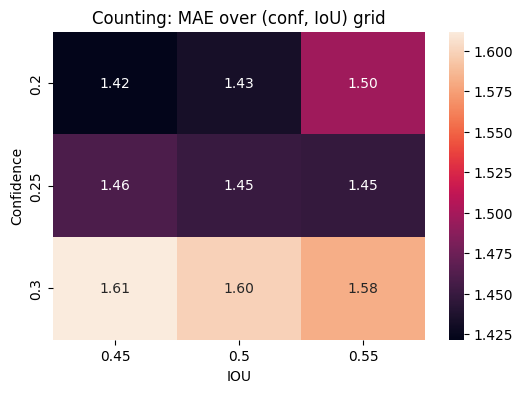

In [45]:
# Threshold sweep heatmap: MAE vs (conf, IoU)
pivot_mae = sweep_df.pivot(index = "conf", columns = "iou", values = "MAE")
plt.figure(figsize = (6, 4))
sns.heatmap(pivot_mae, annot = True, fmt = ".2f")
plt.title("Counting: MAE over (conf, IoU) grid")
plt.xlabel("IOU")
plt.ylabel("Confidence")
plt.show()

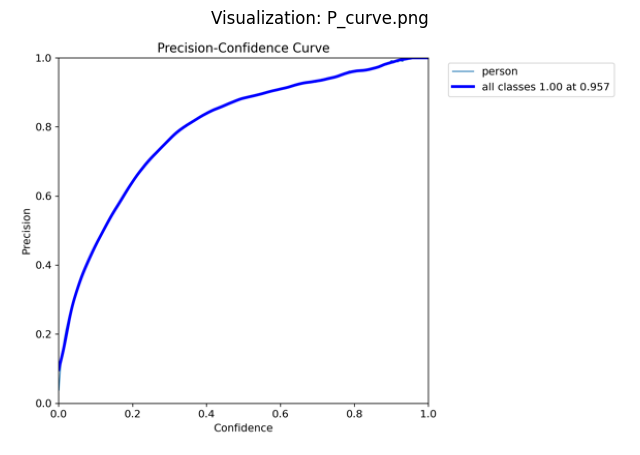

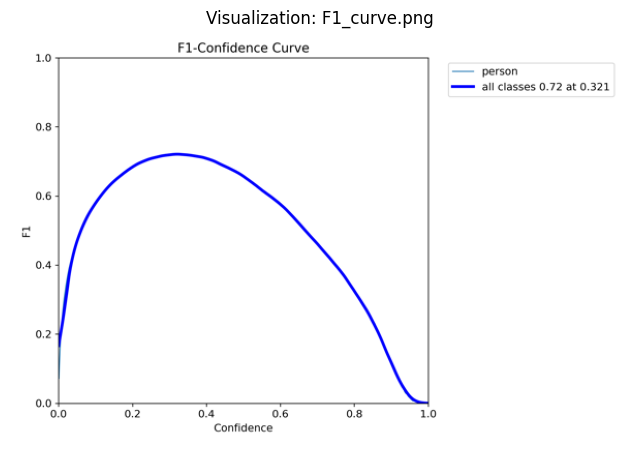

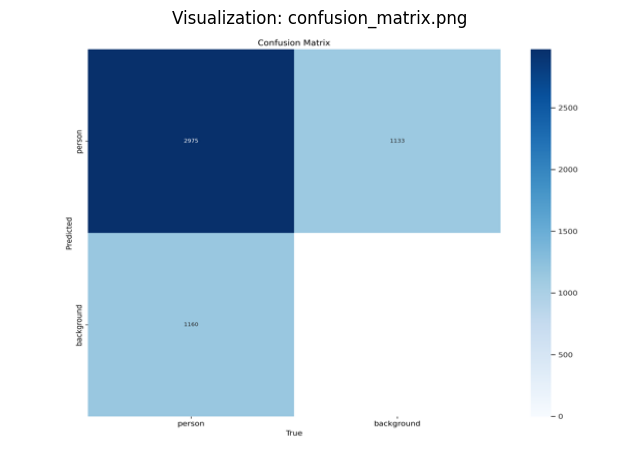

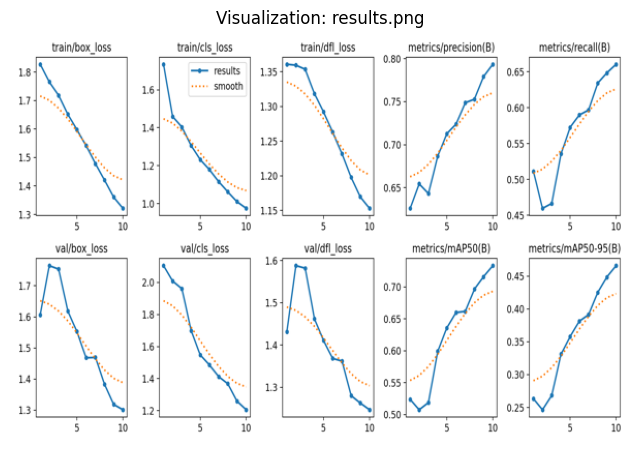

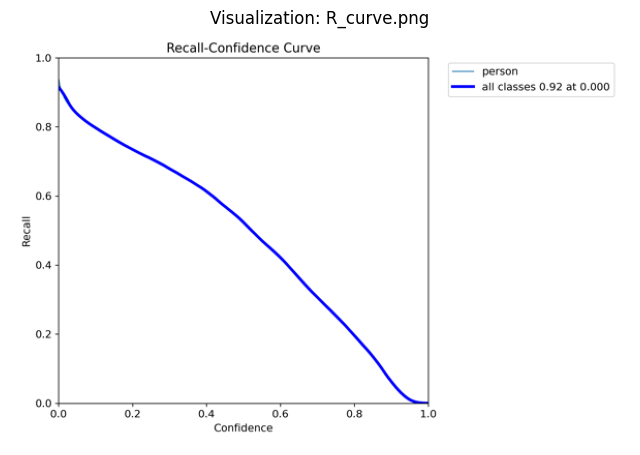

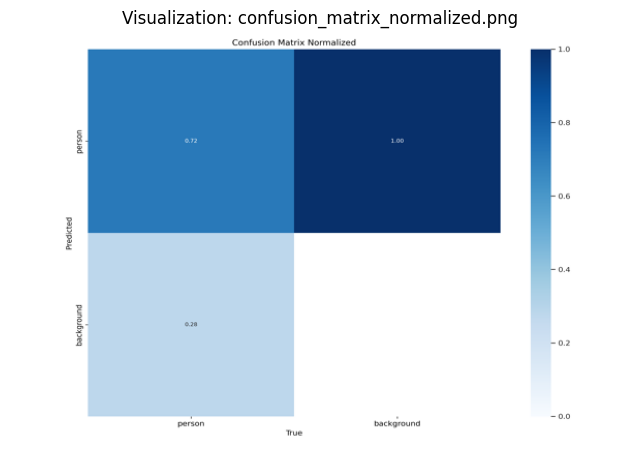

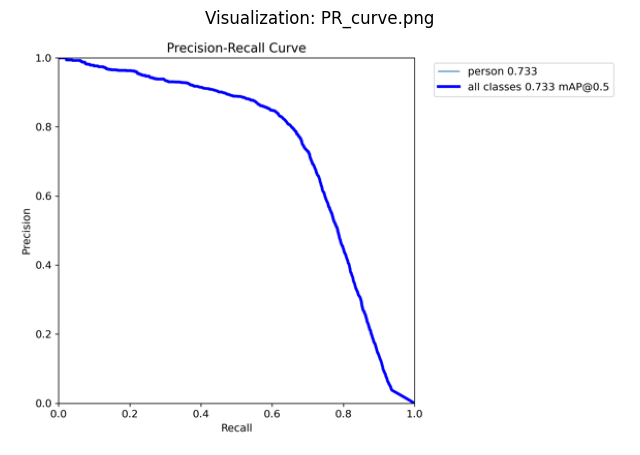

In [46]:
model_runs_dir = runs_dir / "final_model"

# loop through result visualization images
import matplotlib.pyplot as plt
from PIL import Image
png_files = [f for f in os.listdir(model_runs_dir) if f.endswith(".png")]

# Loop through each .png file and display it
for png_file in png_files:
    file_path = os.path.join(best_run_dir, png_file)
    image = Image.open(file_path).resize((600, 400))
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {png_file}")
    plt.show()

## Batch inference on test set (unseen data)

In [52]:
test_img_dir = data_root / "test" / "images"
test_lbl_dir = data_root / "test" / "labels"

num_samples = 5
conf_thresh = 0.15
iou_thresh = 0.50

# Collect test images
test_images = sorted(
    p for p in test_img_dir.iterdir()
    if p.suffix.lower() in image_exts
)

sample_imgs = random.sample(test_images, k=min(num_samples, len(test_images)))

def load_gt_count(lbl_path: Path) -> int:
    if not lbl_path.exists():
        return 0
    lines = [ln for ln in lbl_path.read_text().splitlines() if ln.strip()]
    return len(lines)

def draw_predictions(img_path: Path, results):
    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im)
    w, h = im.size

    n_pred = 0

    if results.boxes is not None and results.boxes.cls.numel() > 0:
        for box, cls in zip(results.boxes.xyxy, results.boxes.cls):
            x1, y1, x2, y2 = box.tolist()

            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)

            # Draw label
            label = "person"
            text_pos = (x1 + 2, max(y1 - 12, 2))
            draw.text(text_pos, label, fill="lime")

            n_pred += 1

    return im, n_pred




2008_002848_jpg.rf.31a25d377cb50bb5b401a70cc3bea38e.jpg
Ground truth count: 2
Predicted count:    3


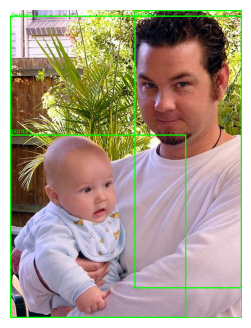

2007_006841_jpg.rf.cdc00183ebc2771e932eb4f907e49971.jpg
Ground truth count: 2
Predicted count:    4


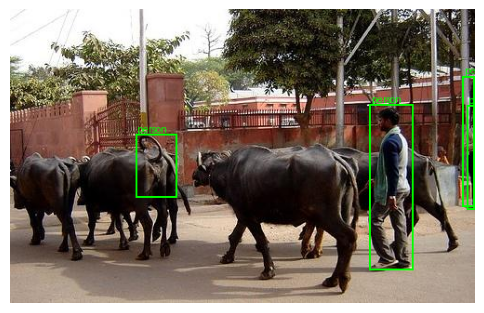

2008_002558_jpg.rf.89dd2c852cf9efe109d82ddc8aa0e5c9.jpg
Ground truth count: 1
Predicted count:    1


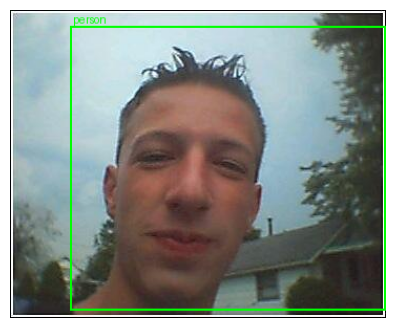

2007_003020_jpg.rf.498681dd168aa3a1bf5c0575146e103b.jpg
Ground truth count: 4
Predicted count:    4


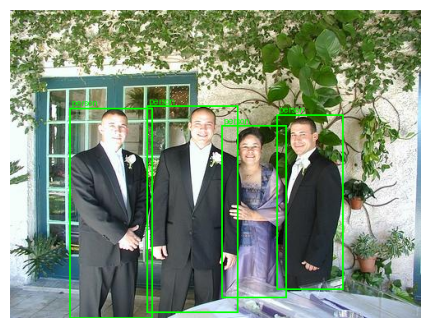

2008_000719_jpg.rf.2fbf3b093ad917edd71c35ed3ba12615.jpg
Ground truth count: 1
Predicted count:    1


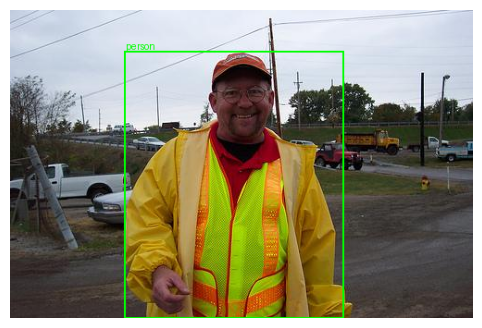

In [53]:
#  Run inference & display
for img_path in sample_imgs:
    lbl_path = test_lbl_dir / f"{img_path.stem}.txt"
    gt_count = load_gt_count(lbl_path)

    results = final_model.predict(
        source=str(img_path),
        imgsz=best_imgsz,
        conf=conf_thresh,
        iou=iou_thresh,
        max_det=300,
        verbose=False,
    )[0]

    annotated_img, pred_count = draw_predictions(img_path, results)

    print(f"{img_path.name}")
    print(f"Ground truth count: {gt_count}")
    print(f"Predicted count:    {pred_count}")

    plt.figure(figsize=(6, 4))
    plt.imshow(annotated_img)
    plt.axis("off")
    plt.show()